In [1]:
from getpass import getpass
token = getpass('GitHub Token: ')

!git clone https://{token}@github.com/JasonDai1219/Transferring_Time.git
%cd Transferring_Time

GitHub Token: ··········
Cloning into 'Transferring_Time'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 110 (delta 0), reused 8 (delta 0), pack-reused 101 (from 1)
Receiving objects: 100% (110/110), 48.77 MiB | 15.09 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/Transferring_Time


In [2]:
!git checkout yanqian

Branch 'yanqian' set up to track remote branch 'yanqian' from 'origin'.
Switched to a new branch 'yanqian'


## Load Dataset

In [1]:
import sys
sys.path.append("/content/Transferring_Time")
from src.data.dataset_foodseg import FoodSegDataset
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random

# Parameters
image_width = 450
image_height = 250
num_classes = 104  # 103 classes + background
batch_size = 4

img_transform = transforms.Compose([
    transforms.Resize((image_width, image_height)),
    transforms.ToTensor()
])
mask_transform = transforms.Compose([
    transforms.Resize((image_width, image_height)),
])

# Row train + val dataset
train_dataset_orig = FoodSegDataset(split="train", img_transform=img_transform, mask_transform=mask_transform)
val_dataset_orig = FoodSegDataset(split="validation", img_transform=img_transform, mask_transform=mask_transform)
full_dataset = train_dataset_orig + val_dataset_orig

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [2]:
# Split dataset -> train(80%) + val(10%) + test(10%)
total_len = len(full_dataset)
train_len = int(total_len * 0.8)
val_len = int(total_len * 0.1)
test_len = total_len - train_len - val_len

indices = list(range(total_len))
random.shuffle(indices)

train_indices = indices[:train_len]
val_indices = indices[train_len:train_len + val_len]
test_indices = indices[train_len + val_len:]

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)
print(f"Train: {len(train_dataset)}  Val: {len(val_dataset)}  Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Train: 5694  Val: 711  Test: 713


## Model & Optimizer

In [3]:
import torch
import torch.nn as nn
from src.model.UNet import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()  # segmentation loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Training

In [ ]:
import os
save_path = "output/"
os.makedirs(save_path, exist_ok=True)

epochs = 10
valid_interval = 2
train_losses = []
valid_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs) # (B, num_classes, H, W)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")

    if ((epoch + 1) % valid_interval == 0):
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(device), mask.to(device)
                output = model(img)
                loss = loss_fn(output, mask)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        valid_losses.append(val_loss)
        print(f"[Epoch {epoch+1}] Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path+"unet.pth")
            print(f"New best model saved (val loss = {best_val_loss:.4f})")


Epoch 1 loss: 2.7787
Epoch 2 loss: 2.0721
[Epoch 2] Validation Loss: 1.9290
New best model saved (val loss = 1.9290)
Epoch 3 loss: 1.9392
Epoch 4 loss: 1.8689
[Epoch 4] Validation Loss: 1.8107
New best model saved (val loss = 1.8107)
Epoch 5 loss: 1.8087
Epoch 6 loss: 1.7624
[Epoch 6] Validation Loss: 1.6843
New best model saved (val loss = 1.6843)
Epoch 7 loss: 1.7155
Epoch 8 loss: 1.6761
[Epoch 8] Validation Loss: 1.6178
New best model saved (val loss = 1.6178)
Epoch 9 loss: 1.6394
Epoch 10 loss: 1.6051
[Epoch 10] Validation Loss: 1.6104
New best model saved (val loss = 1.6104)


## Testing and visualization

In [ ]:
print(save_path+"unet.pth")

In [8]:
# Load best weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=num_classes).to(device)
model.load_state_dict(torch.load(save_path + "unet.pth", map_location=device))

model.eval()
test_loss = 0.0
with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        loss = loss_fn(output, mask)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Testing Loss: {test_loss:.8f}, ')

Testing Loss: 1.63094260, 


### Sampling Visualization

In [12]:
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Simple color map (random)
np.random.seed(42)
COLORMAP = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)

def visualize(img, mask, pred):
    img = img.permute(1,2,0).cpu().numpy()
    mask_color = COLORMAP[mask.cpu().numpy()]
    pred_color = COLORMAP[pred.cpu().numpy()]

    fig, ax = plt.subplots(1,3, figsize=(10,4))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask_color)
    ax[1].set_title("Ground Truth")
    ax[2].imshow(pred_color)
    ax[2].set_title("Prediction")
    plt.show()


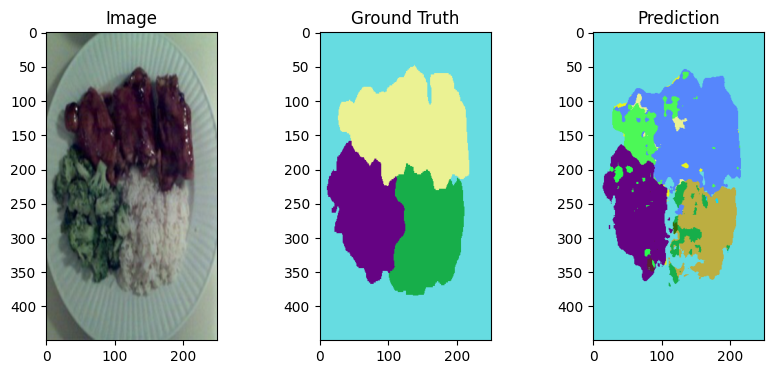

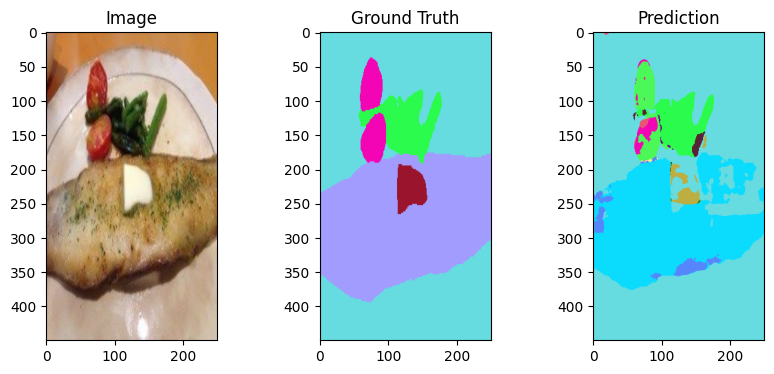

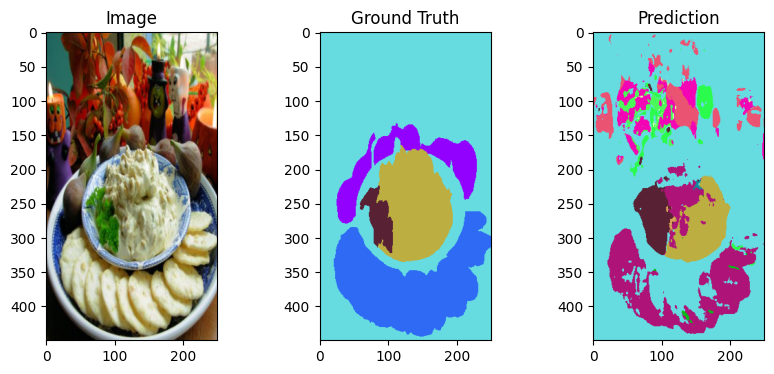

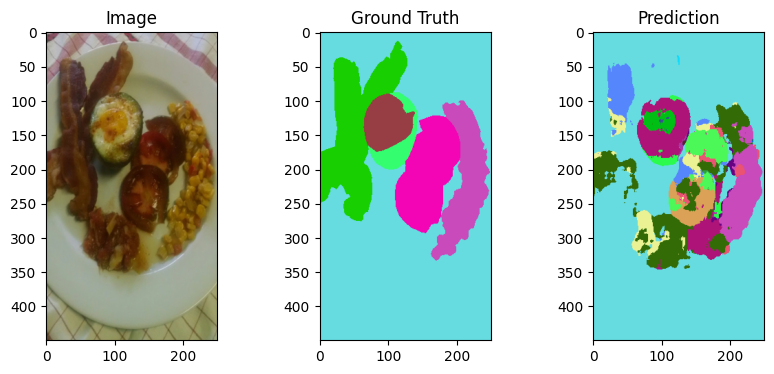

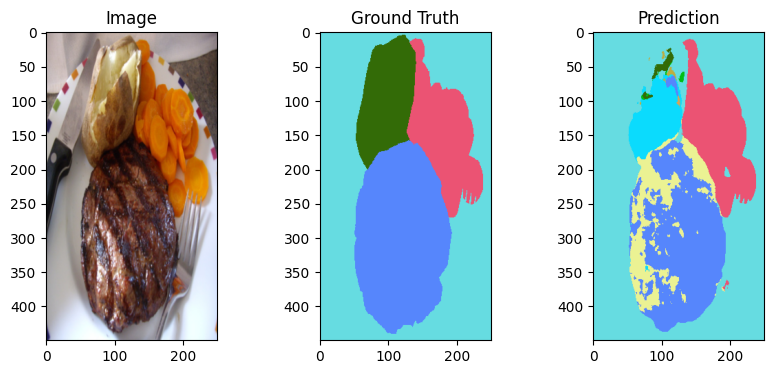

In [13]:
model.eval()
num_samples = 5
# Randomly selected images from the test set
test_indices = np.random.choice(len(test_dataset), num_samples, replace=False)
with torch.no_grad():
    for idx in test_indices:
        img, mask = test_dataset[idx]
        img_input = img.unsqueeze(0).to(device)
        mask = mask.to(device).unsqueeze(0)

        pred = torch.argmax(model(img_input), dim=1)
        visualize(img, mask[0], pred[0])

## Plot Loss Curve

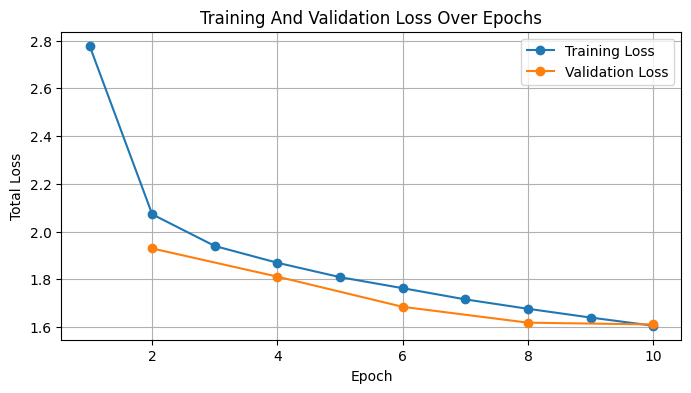

In [16]:
# Generate the epoch list corresponding to the x axis
total_epochs = epochs
epoch_list = list(range(1, total_epochs + 1))
valid_epochs = list(range(valid_interval, total_epochs + 1, valid_interval))
#test_epochs = list(range(test_interval, len(train_losses) + 1, test_interval))

plt.figure(figsize=(8, 4))
plt.plot(epoch_list, train_losses, label='Training Loss', marker='o')
plt.plot(valid_epochs, valid_losses, label='Validation Loss', marker='o')
#plt.plot(test_epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training And Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.savefig(save_path+'loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()
